<div style='font-size:30px; color:green; font-weight: bold; margin-bottom: 20px'>Model Builder Template</div> 
 			<div style='font-size:25px; font-weight: bold'>Overview</div>

* 			This template is used for seamless integration with CDMS serving layer by preparing `custom_model.py` and `metadata.json` files.
* 			When this template is opened, a folder with name same as Model Code was created in the local. 
* 			The cells with code containing <i>import statements</i> or <i>function definitions</i> will be extracted to the `custom_model.py`.
* 			Please refer to the Model Onboarding User Guide to get the detailed working of this template.

<div style='font-size:20px'>Note: Rename your notebook file to some meaningful model before doing 			any model development. Changing notebook name after onboarding can make your code behave erroneously.</div>

!nbdiff-web -p 39659 --ip 0.0.0.0 dc4fcdf4ee985b8945a8b2decd7dda1dc6305166 ddcfa3d6be3bf53523925abf96f4e597b9d9fc44
exit

!nbdiff dc4fcdf4ee985b8945a8b2decd7dda1dc6305166 ddcfa3d6be3bf53523925abf96f4e597b9d9fc44

In [5]:
1

1

## 1. Model Information

### 1.1 Initialize metadata

In [1]:
initialize_metadata()

<IPython.core.display.Javascript object>

### 1.2 Meta data Information
* 			Please enter a unique model code, model name (e.g. Customer Churn, Propensity to Default, CLTV etc) and Model description.
* 			Please ensure the 'Create Workspace' button is clicked.
* 			For more information, please refer to the User Guide.

In [2]:
enter_metadata_information(1)

Button(description='Create Workspace', style=ButtonStyle())

Output()

## 2. Import Packages
* 			The following cell can be used to import all the required python packages.
* 			Please import the `gr` package to use the pre-defined models and functionalities. 			For more information, please refer to the User Guide.

In [3]:
#imports 
import os, sys, pickle;

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret import classification
import s3fs
#s3 file location
#s3://ins-data-lake/insfiles/insurance_claims.csv
#s3://ins-data-lake/insfiles/insurance_claims_test.csv

pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

## 3. Read Data from Source
* 			The following code snippet can be used to read the data from different types of sources.
* 			Please provide the correct details and appropriate queries to read the data. **Note**: This is optional.
* 			The data can also be read using the functionality provided by the `gr` package.
* 			To read from s3 use: df = read_data('s3://file Path')

df=get_data_from_db(
dbtype='postgresql',
username='retailuser',
password='XXXXXXX',
host='172.18.128.14',
port='5533',
database_name='APT_POC',
sql_query='select * from <<table>>'
)
df.shape

In [2]:
def read_data(inpath):
    return pd.read_csv(inpath)

In [3]:
df = read_data('s3://ins-data-lake/insfiles/insurance_claims.csv')

In [4]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


## 4. Exploratory Data Analysis 
* 			The following code snippet provided can be used to get first hand information on the dataset that is going to be analysed. 
* 			After fetching details to `pandas.dataframe df`, please execute the shell to get the data analysis report. 
* 			<div style='font-size:15px; font-weight: bold'>Warning** : This is not recommended for a huge dataset as it may take a longer time to generate the report.</div>

In [ ]:
exploratory_data_analysis(df)

### Data Cleansing

In [7]:
def prepare_data(df):
    #extract out the year as 

    df['policy_bind_year']=df['policy_bind_date'].str.extract('(\d{4})').astype('int32')

    #df['incident_month']=df['incident_date'].str.extract('\d{4}\-(\d{2})').astype('int32')
    df['incident_month'] = df['incident_date'].str.extract('-(\d{2})-').astype('int32')

    #replace "?" with undocumented 

    df['collision_type'] = df['collision_type'].replace("?", "undocumented")
    df['police_report_available'] = df['police_report_available'].replace("?", "undocumented")
    df['property_damage'] = df['property_damage'].replace("?", "undocumented")
    df['auto_make'] = df['auto_make'].replace("Suburu", "Subaru")

    #incident_severity can be seen as ordinal
    #code them in order of severity 

    df['incident_severity'] = df['incident_severity'].map({"Trivial Damage":0,
                                                           "Minor Damage":1,
                                                           "Major Damage":2,
                                                           "Total Loss":3
                                                          }).astype("int32")

    all_var = list(df.columns)
    #len(all_var)

    #continuous variables = ordinal, interval, ratio

    cont_var =['age','incident_hour_of_the_day',
               'number_of_vehicles_involved','total_claim_amount',
               'injury_claim','property_claim','vehicle_claim',
               'months_as_customer','policy_annual_premium','policy_deductable',
               'umbrella_limit','capital-gains','capital-loss', 
               'auto_year','witnesses','bodily_injuries','policy_bind_year','incident_severity']

    #len(cont_var)

    #ordinal var

    ord_var = ['policy_deductable','witnesses','bodily_injuries','incident_severity']
    #len(ord_var)

    #ord_var

    #quan var = interval or ratio 

    quan_var = (list(set(cont_var) - set(ord_var))) 
    #len(quan_var)

    #norminal aka discrete var

    nom_var = (list(set(all_var) - set(cont_var))) 
    #len(nom_var)

    #for those that have not too many unique, we can plot them out

    large_cat = []

    for col in nom_var:
        if df[col].nunique() > 20:
            large_cat.append(col)
            print(col, df[col].nunique())
        else: 
            pass

    #incident location, insured zip, policy bind date, policy number too many unique to be meaningful

    #get a data frame with var that have large num categories
    #only auto model 
    large_dummy = pd.get_dummies(df[['auto_model','incident_date']], drop_first=True)

    try:
        #put in the DV
        large_dummy['fraud_reported']=df['fraud_reported']

        #numerical code the DV
        large_dummy['fraud_reported'] = large_dummy['fraud_reported'].map({"Y":1,"N":0})
    except Exception:
        print('Item not found')

    #unique to each case. wont be useful
    #large_dummy.head(10)

    large_cat.remove('policy_number')

    #drop this variables from analysis 

    df.drop(large_cat, axis=1, inplace=True)

    try:
        nom_var.remove('fraud_reported')
    except Exception:
        print('item doesnt exist')

    #redefine the norminal var
    #remove dv from the list


    nom_var.remove('policy_number')
    nom_var = (list(set(nom_var) - set(large_cat))) 

    #check columns add up 

    print ('total var count:{}'.format(len(list(df.columns))),
           'continous var count:{}'.format(len(cont_var)),
           'norminal var count:{}'.format(len(nom_var)))
    return df, nom_var, cont_var, ord_var, quan_var

In [8]:
df,nom_var, cont_var,ord_var, quan_var = prepare_data(df)

auto_model 39
policy_number 1000
incident_date 60
incident_location 1000
policy_bind_date 951
insured_zip 995
total var count:36 continous var count:18 norminal var count:16


In [9]:
df.fraud_reported.value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

In [10]:
#proportion of each level of DV
df.fraud_reported.value_counts(normalize=True)

N    0.753
Y    0.247
Name: fraud_reported, dtype: float64

In [ ]:
#dist of dv
#plt.style.use('dark_background') for ppt 

sns.set()
try:
    sns.countplot(x ="fraud_reported", data=df, palette=['r','b']);
except Exception:
    print("Item not found")        

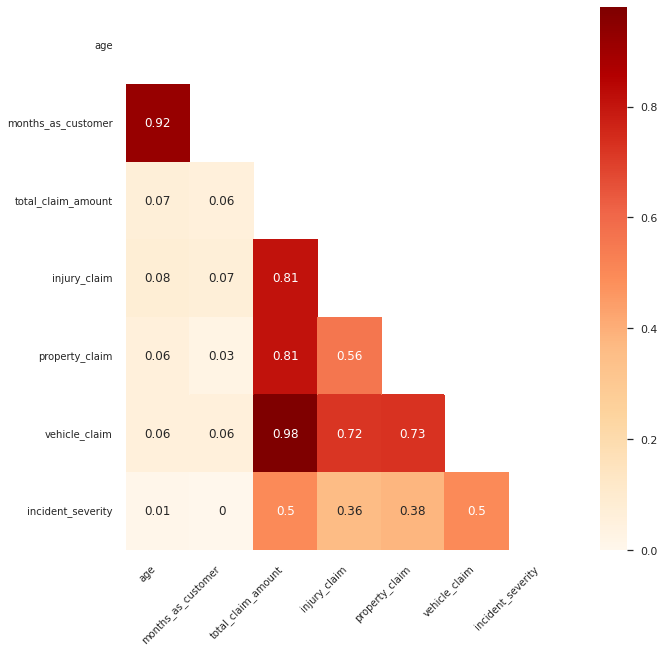

In [12]:
sns.set_style('white')

# heatmap from those with at least 0.3 magnitude in corr, includeing the DV
corr_list=['age','months_as_customer','total_claim_amount',
           'injury_claim', 'property_claim','vehicle_claim',
           'incident_severity','fraud_reported']

try:
    corr_df = df[corr_list]
    corr=round(corr_df.corr(),2)

    # Set the default matplotlib figure size to 7x7:
    fix, ax = plt.subplots(figsize=(10,10))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True  #triu triangle upper

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='OrRd')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha= 'right', rotation=45 )
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
except Exception:
    print("Item not found")

### Visualization

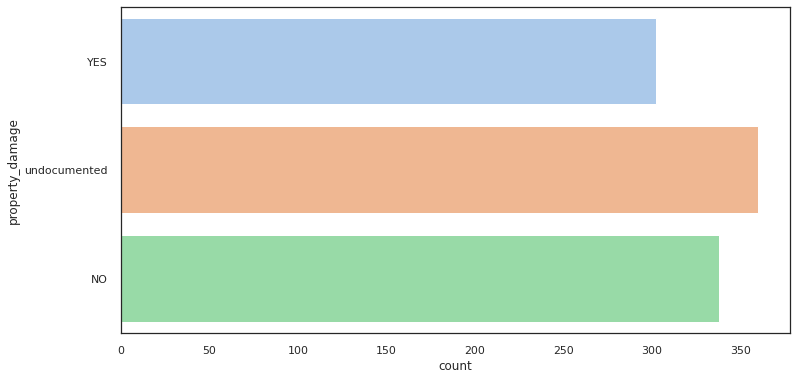

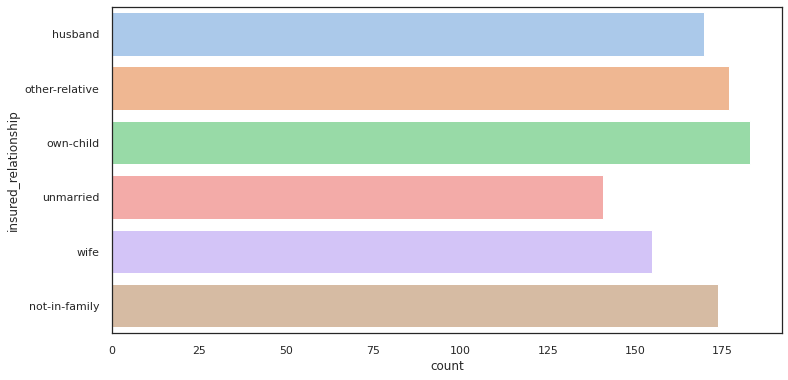

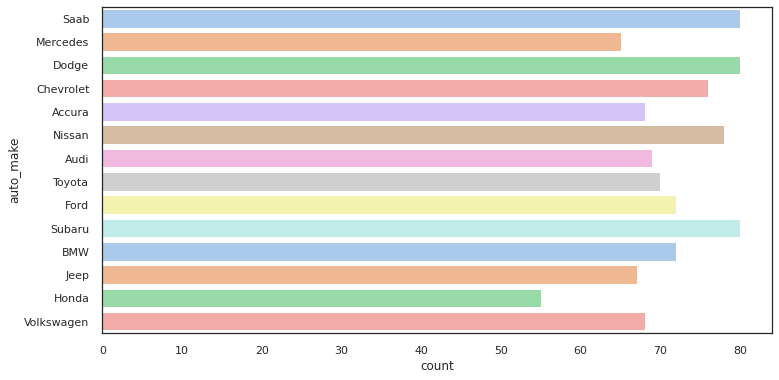

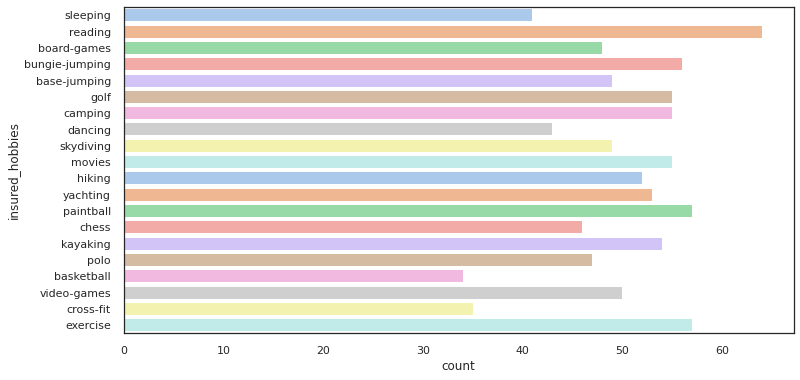

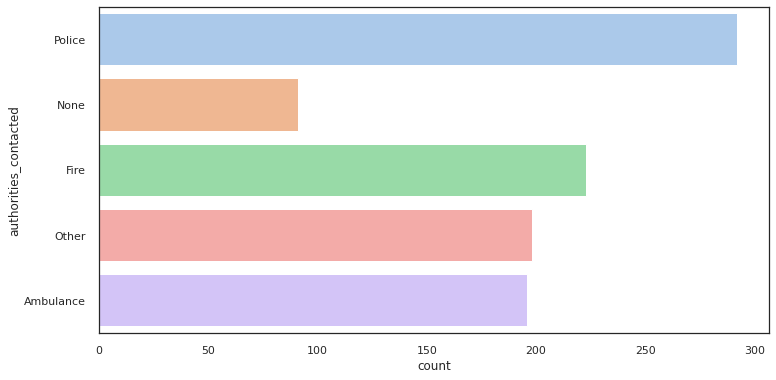

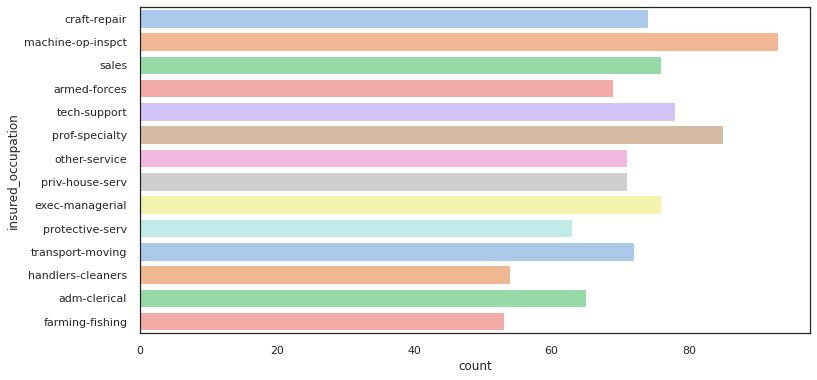

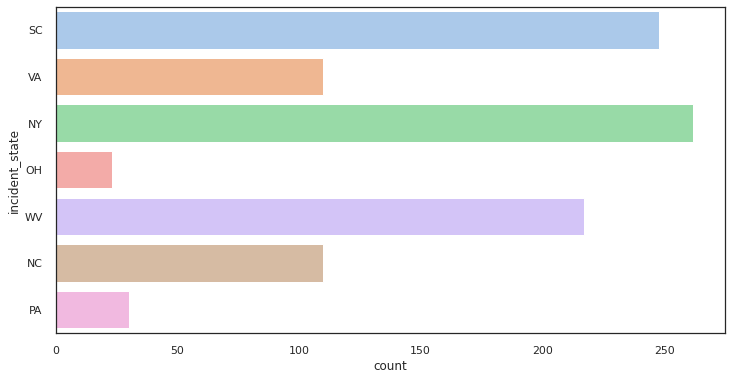

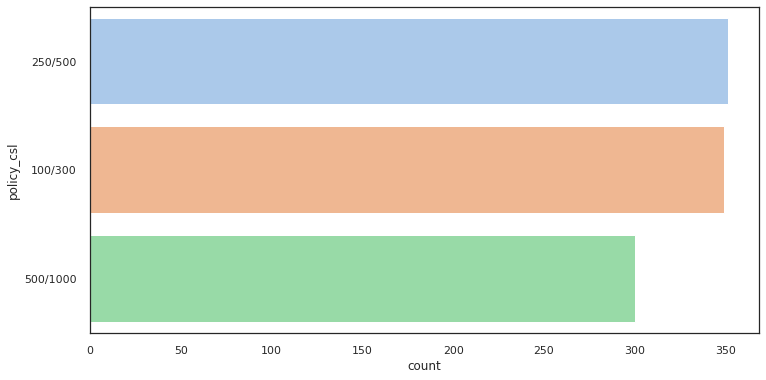

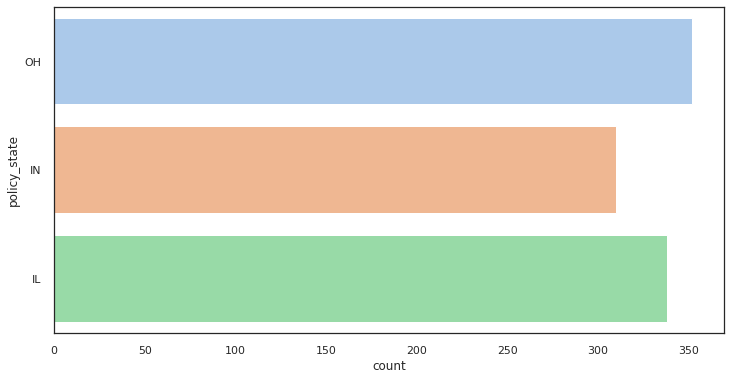

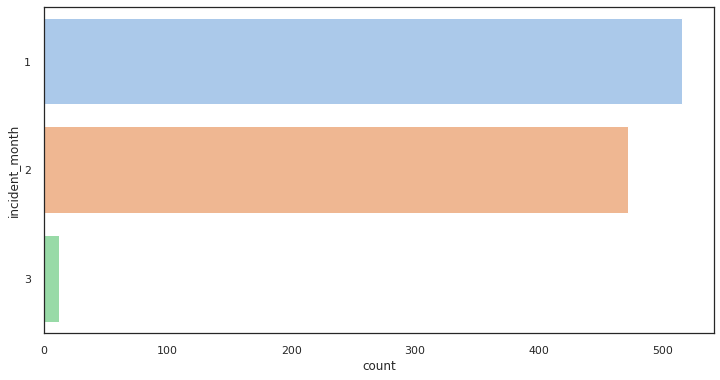

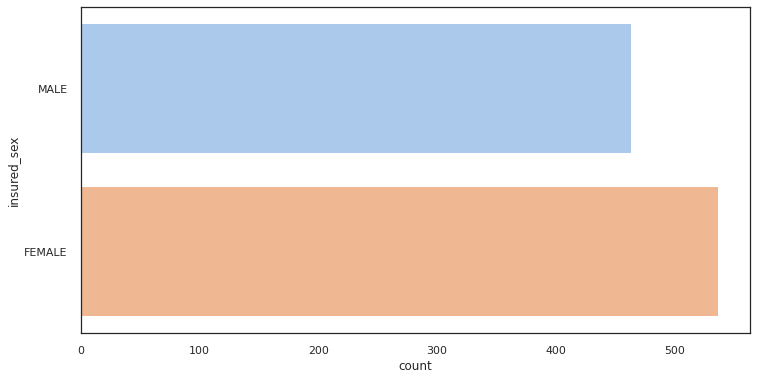

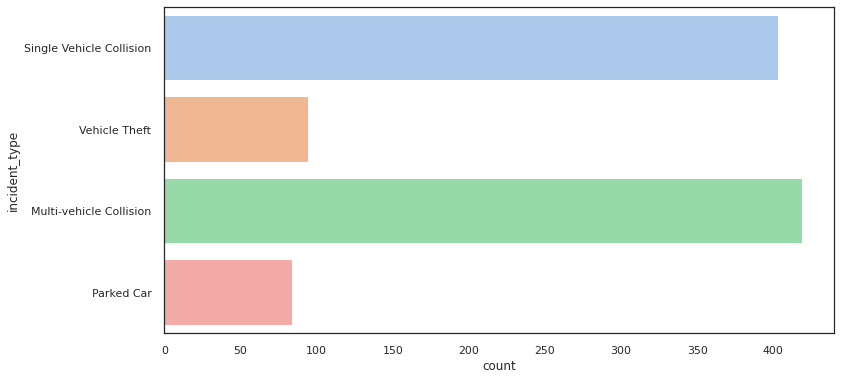

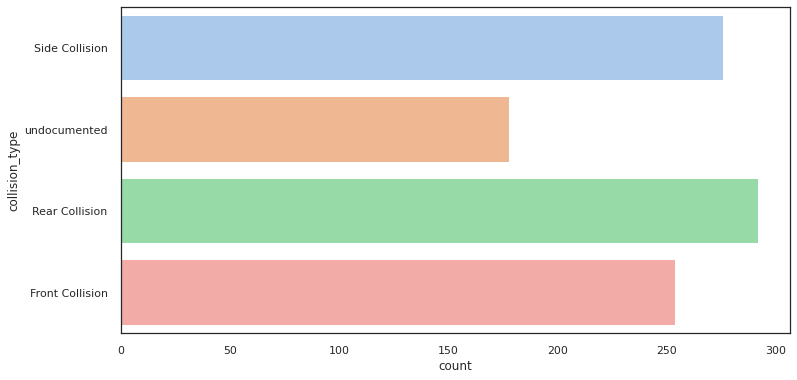

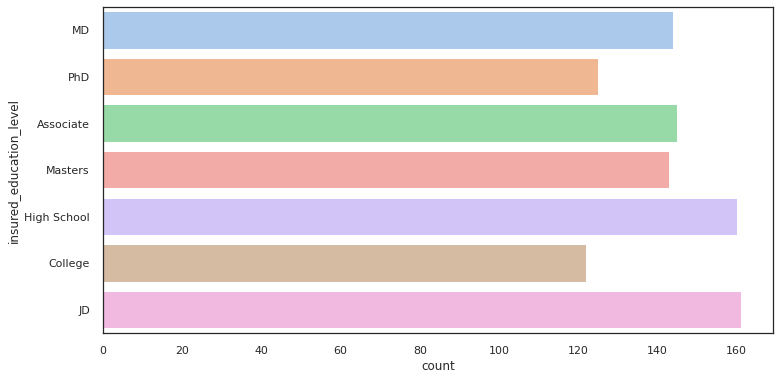

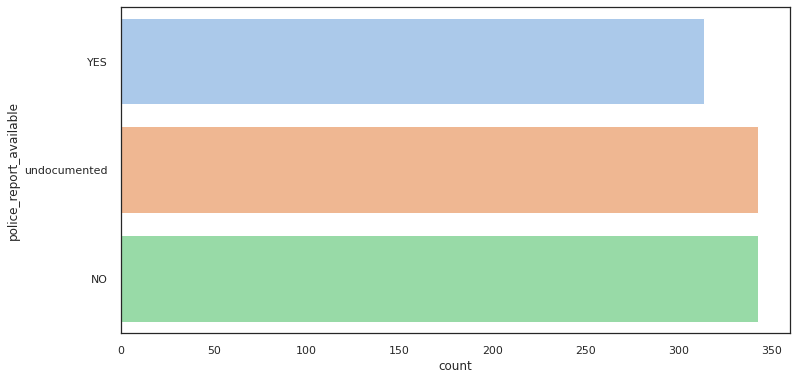

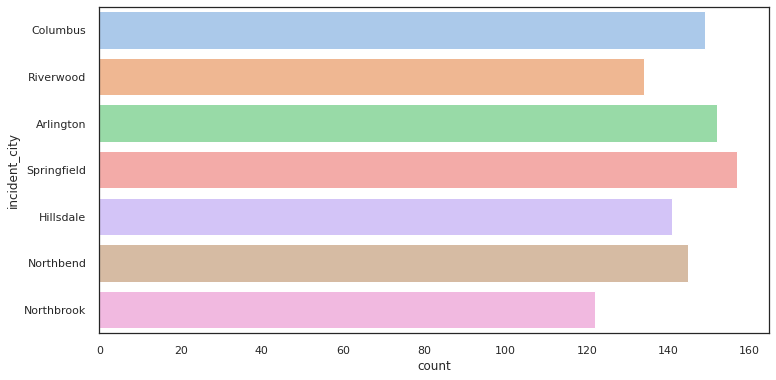

In [14]:
#countplot of discrete var , 
for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(12,6))
    sns.countplot(y=name, data=df, palette="pastel")

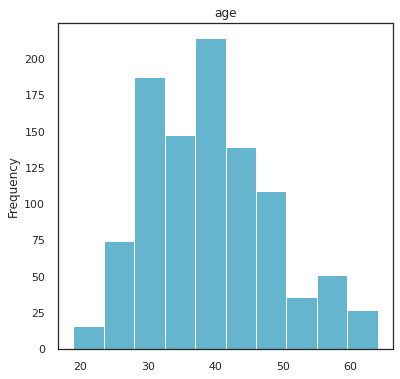

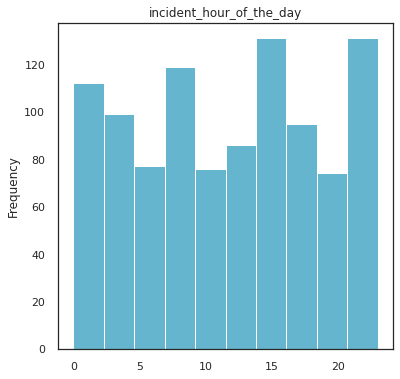

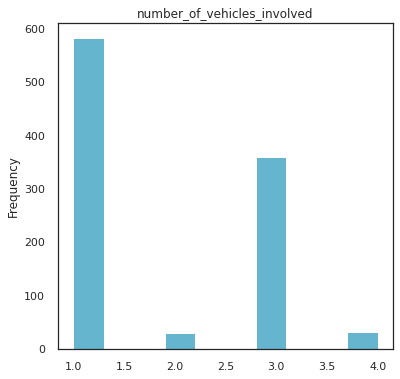

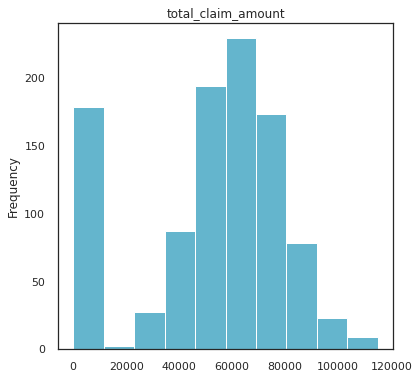

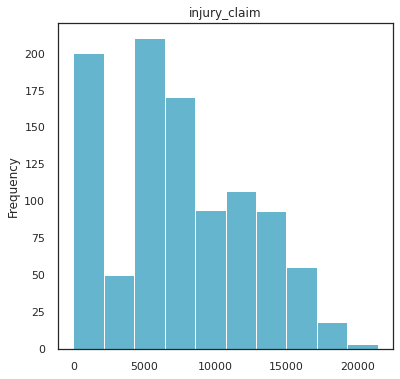

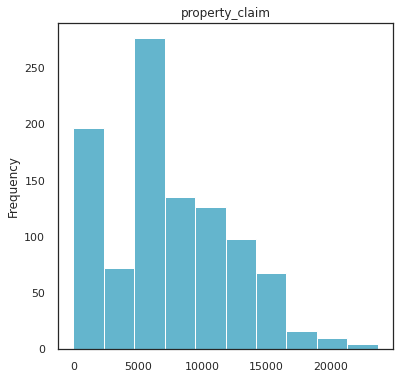

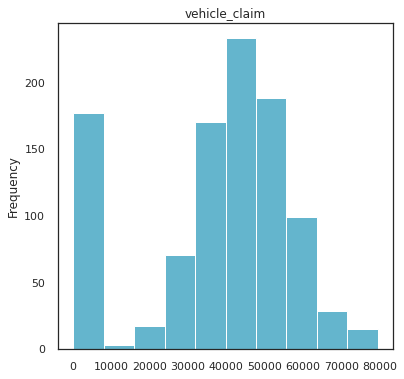

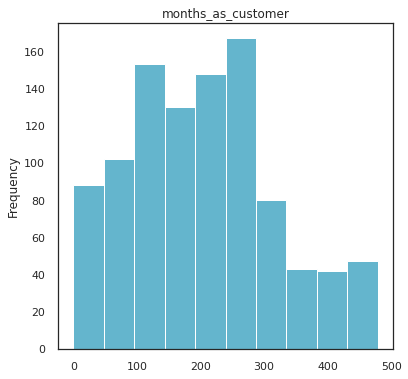

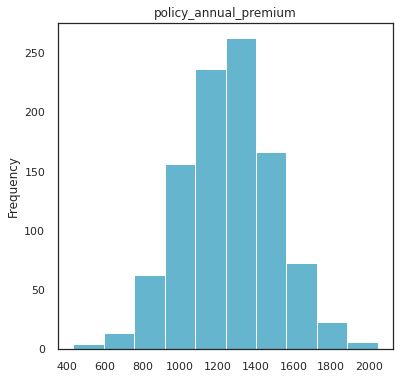

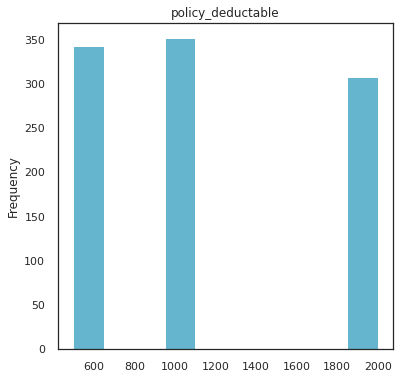

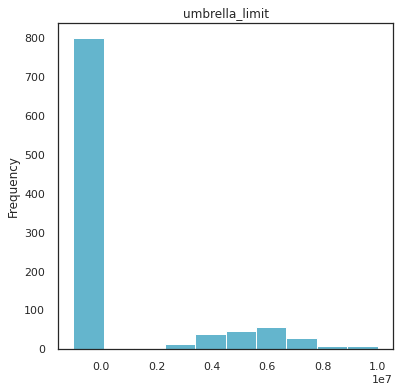

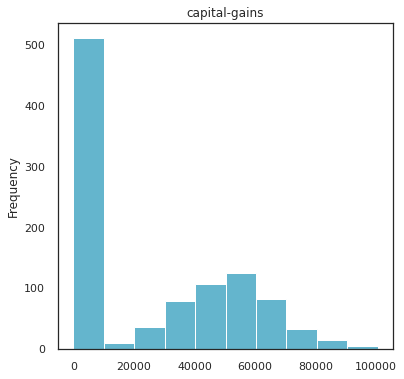

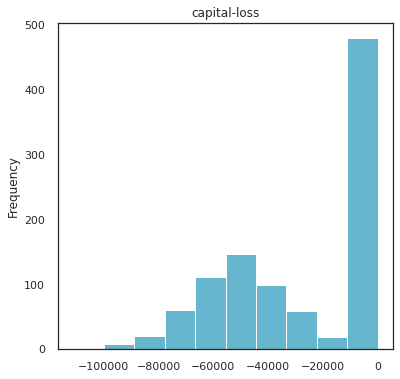

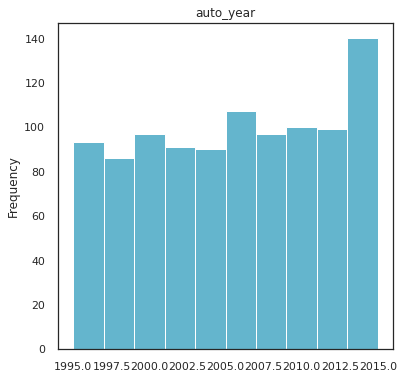

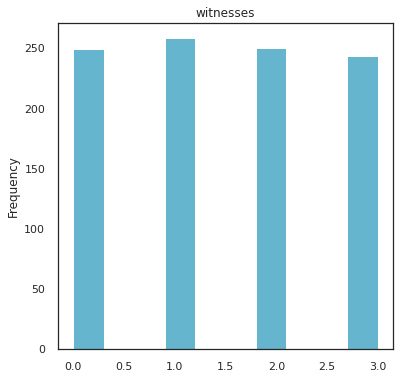

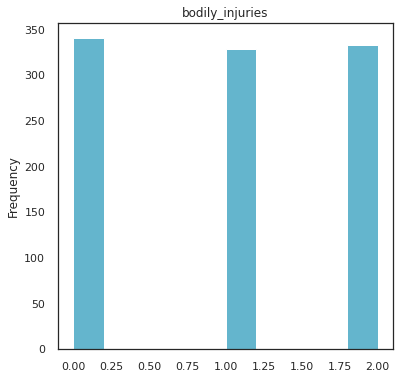

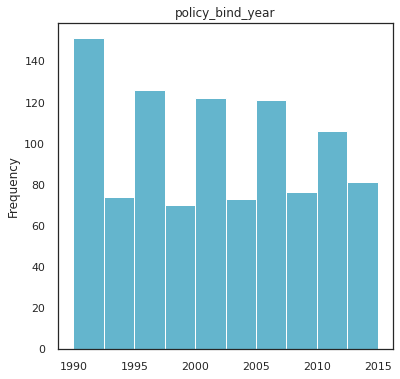

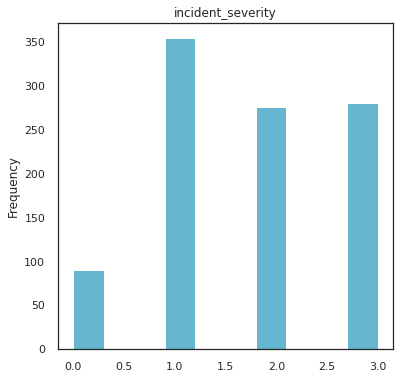

In [15]:
#distribution of ordinal and continuous variables
for i, name in enumerate(df[cont_var]):
    plt.figure(i,figsize=(6,6))
    df[name].plot(kind="hist", color="c", title=name)

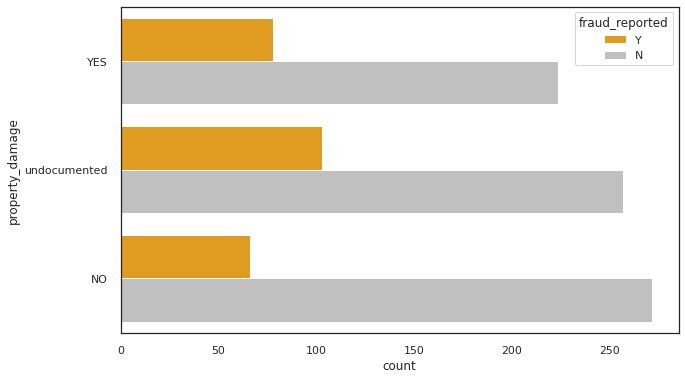

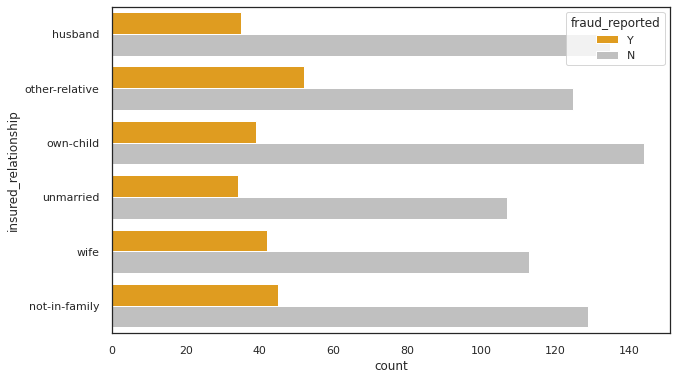

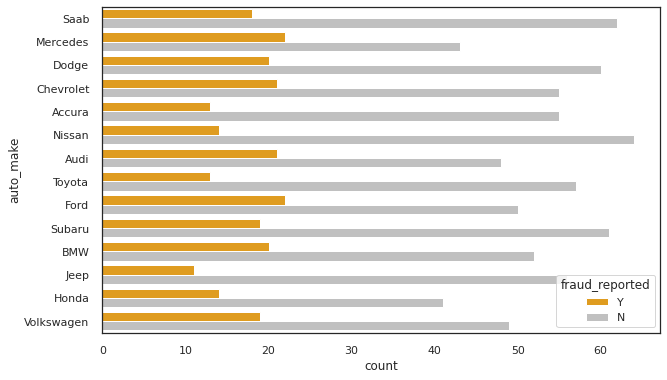

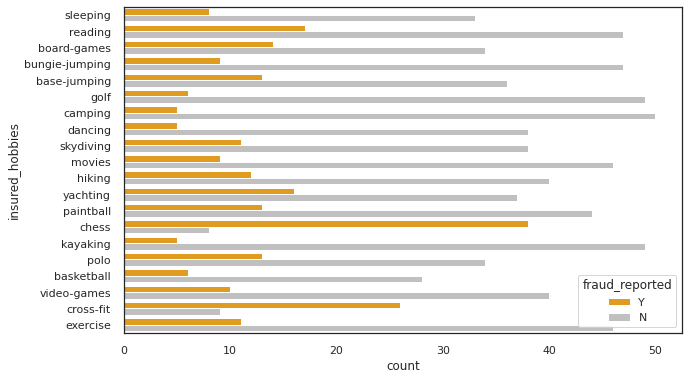

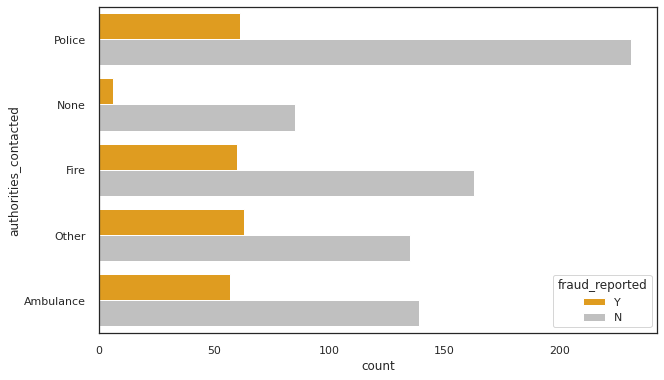

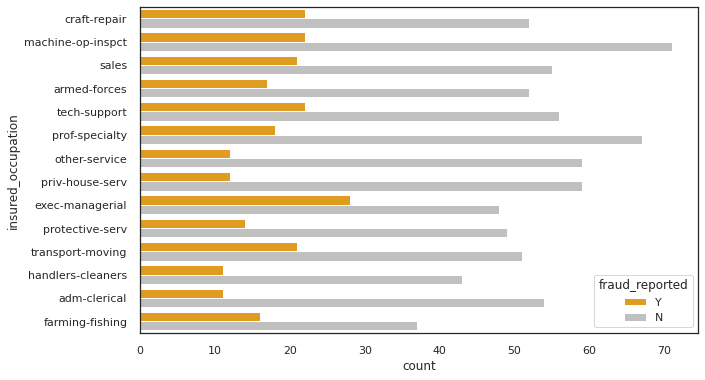

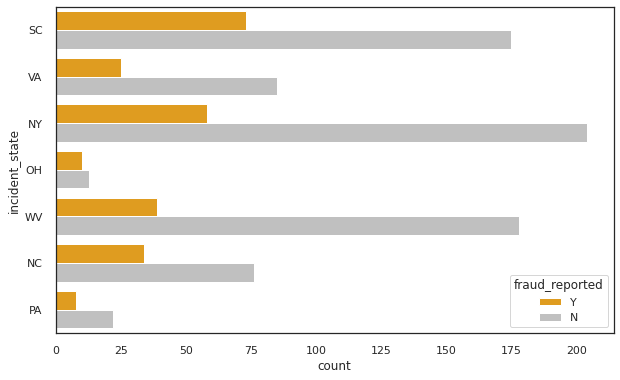

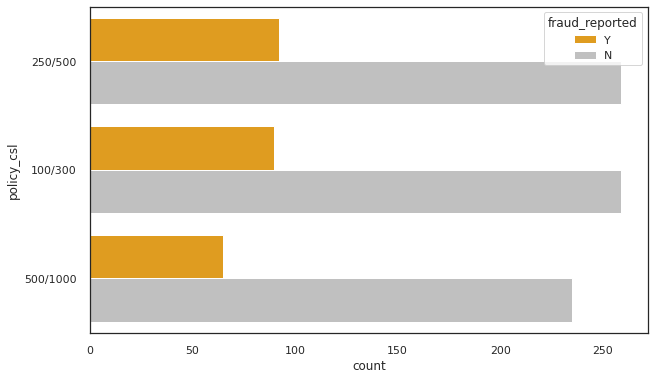

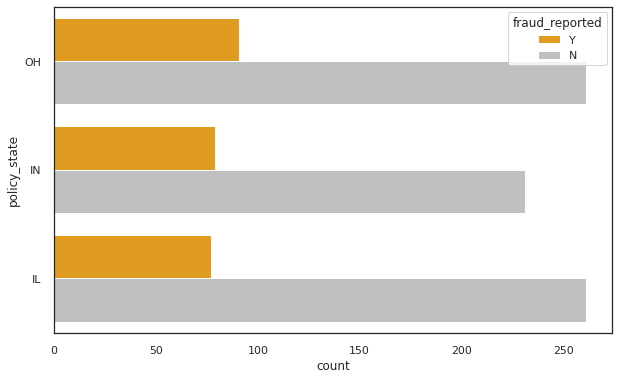

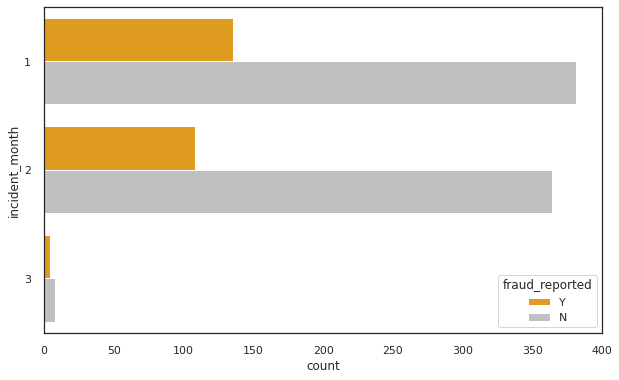

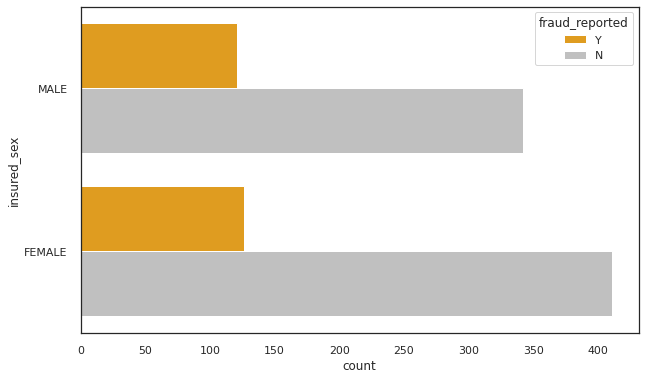

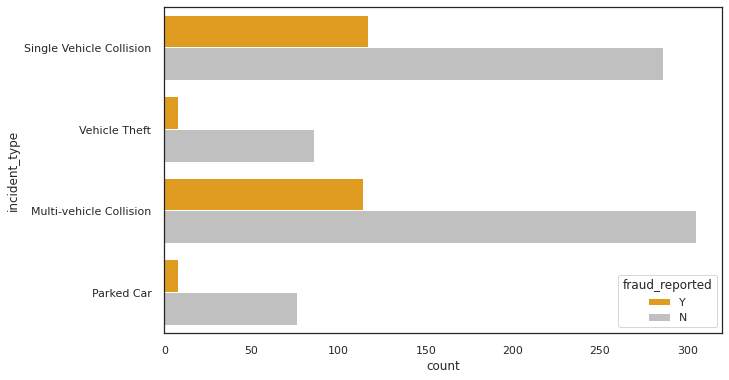

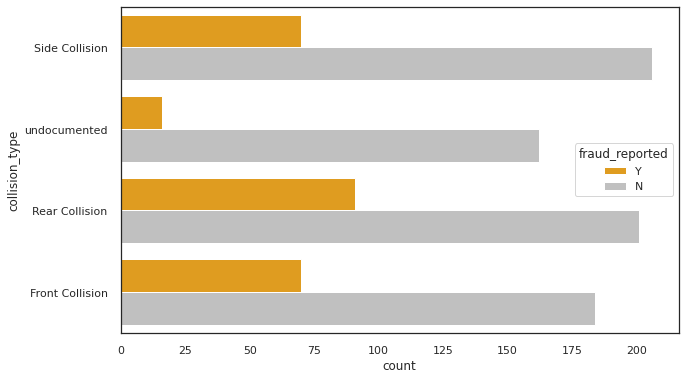

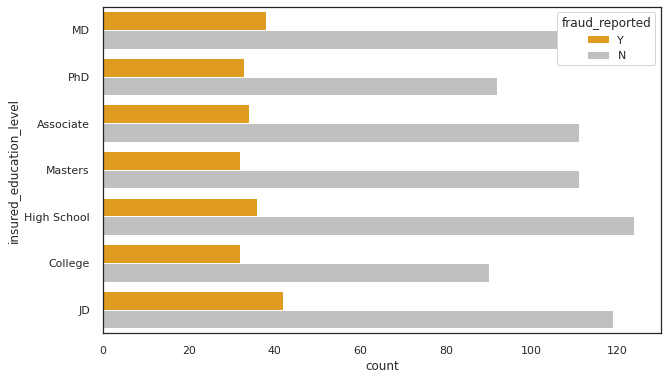

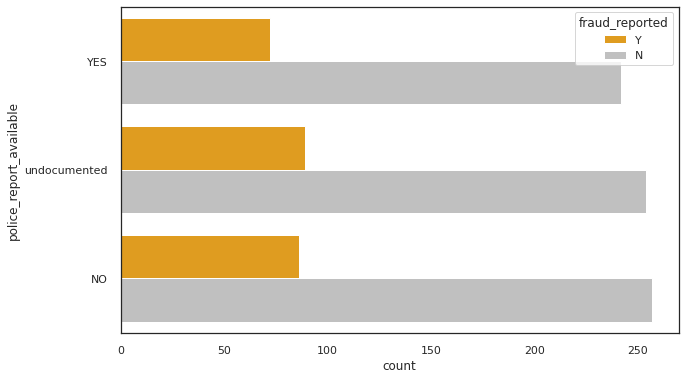

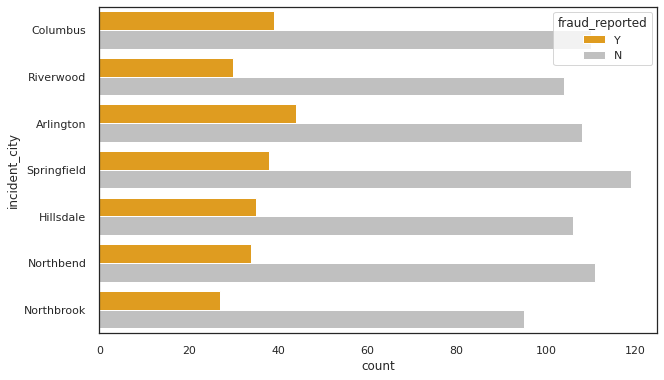

In [22]:
#each discrete var and fraud reported's dist
for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(10,6))
    sns.countplot(y=name, data=df, hue="fraud_reported", palette=['orange','silver'])

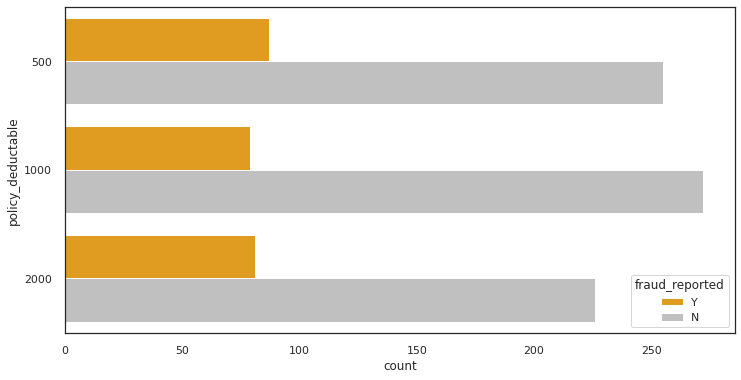

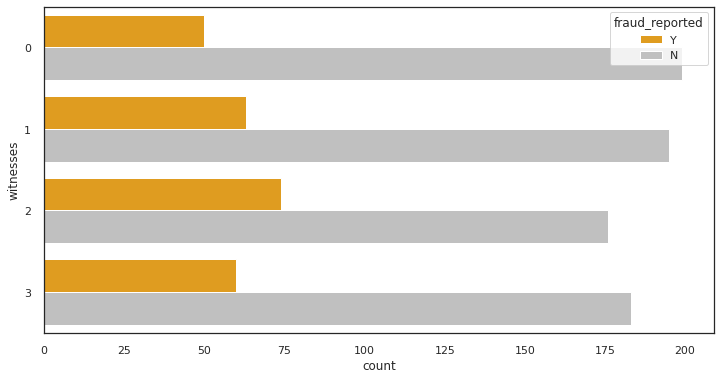

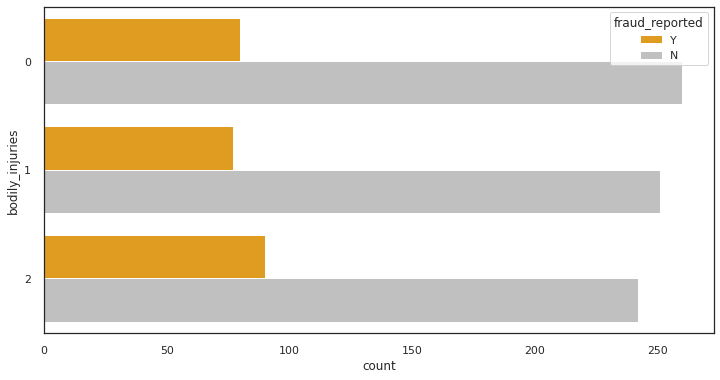

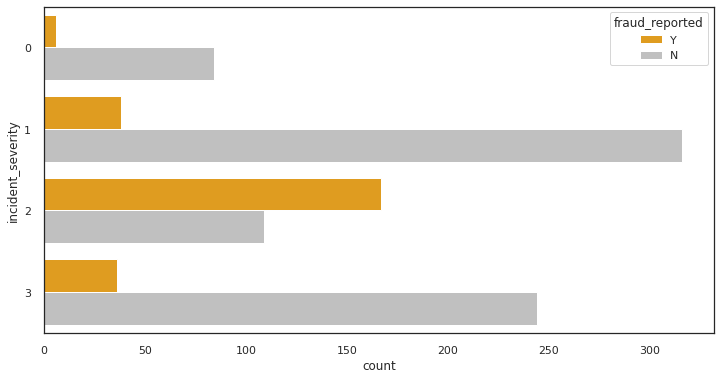

In [23]:
#each ordinal var and fraud reported's dist
#plt.style.use('dark_background')
#plt.style.use('default')
for i, name in enumerate(df[ord_var]):
    plt.figure(i,figsize=(12,6))
    sns.countplot(data=df, y=name, hue='fraud_reported', palette=['orange','silver'])
    

<Figure size 864x432 with 0 Axes>

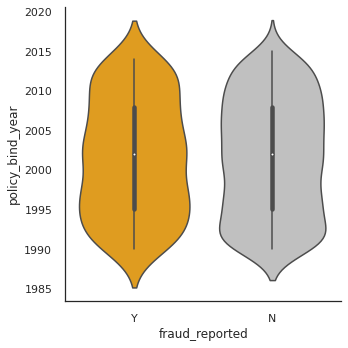

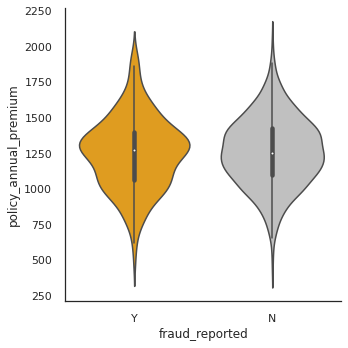

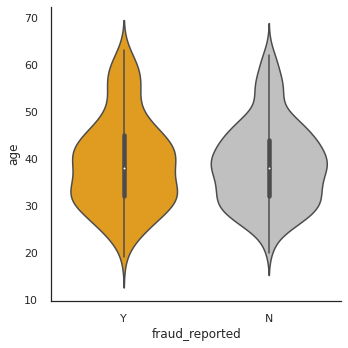

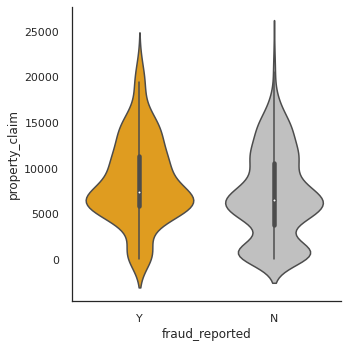

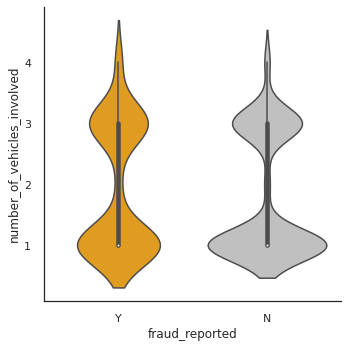

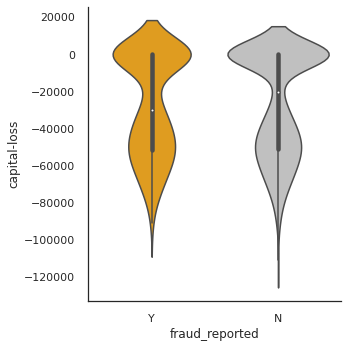

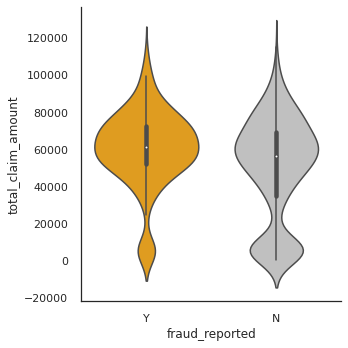

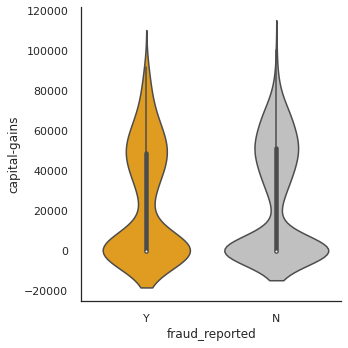

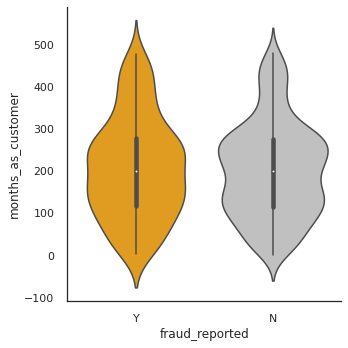

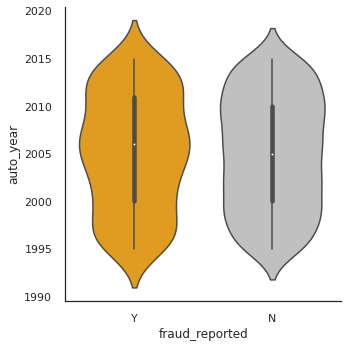

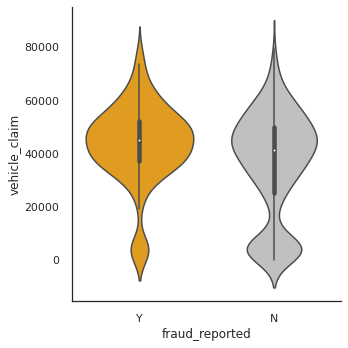

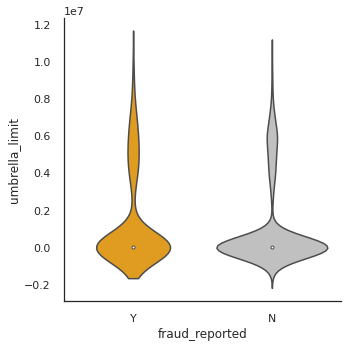

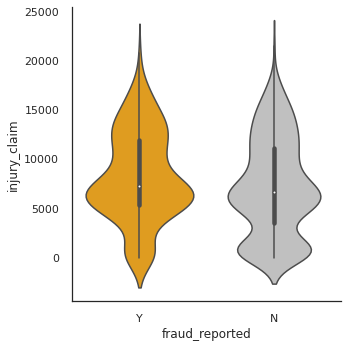

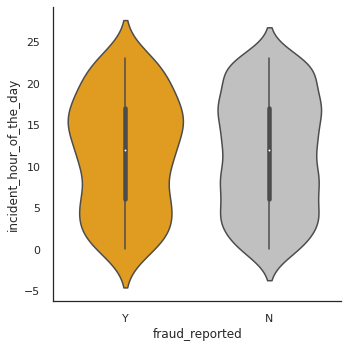

In [24]:
#each continous var and fraud reported's dist
for i, name in enumerate(df[quan_var]):
    plt.figure(i,figsize=(12,6))
    sns.catplot(data=df, x="fraud_reported", y=name, kind='violin', palette=['orange','silver'])
    

## 5. Preprocessing

In [13]:
def preprocess_data(df,nom_var):

    #create a variable that measure how much claims - how much premiums was paid by a client to indeicate a loss/profit

    df['loss_by_claims'] = df['total_claim_amount'] - (df['policy_annual_premium'] * (2015 - df['policy_bind_year']))

    #DV numerical code
    try:
        df['fraud_reported'] = df['fraud_reported'].map({"Y":1, "N":0})
        df['fraud_reported']
    except Exception:
        print("Item not found")

    df['insured_sex'] = df['insured_sex'].map({"FEMALE":0,"MALE":1})

    df['capital-loss']=df['capital-loss']*(-1)

    #check that they are coded

    df['pclaim_severity_int'] = df['property_claim']*df['incident_severity']
    df['vclaim_severity_int'] = df['vehicle_claim']*df['incident_severity']
    df['iclaim_severity_int'] = df['injury_claim']*df['incident_severity']
    df['tclaim_severity_int'] = df['total_claim_amount']*df['incident_severity']

    df['prem_claim_int'] = df['policy_annual_premium']*df['total_claim_amount']
    df['umlimit_tclaim_int'] = df['umbrella_limit']*df['total_claim_amount']


    #### Dummy coding

    rem = ['insured_sex','incident_month','policy_number']
    dum_list = [e for e in nom_var if e not in rem]
    #len(dum_list)

    dum = pd.get_dummies(df[dum_list], drop_first=True)
    #dum.head()

    dum.reset_index(drop=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df_dummied = pd.concat([dum, df], axis=1)

    df_dummied.drop(nom_var, axis=1, inplace=True)

    df_dummied.isnull().sum().any()

    df_dummied['umbrella_limit'].sort_values(ascending=True)
    return df_dummied

In [14]:
df_dummied = preprocess_data(df,nom_var)

## 6. Feature Selection

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def select_features(df, label_col):
    X = df.drop([label_col], axis=1)
    y = df[label_col]

    # Building the model
    sel = SelectFromModel(ExtraTreesClassifier(n_estimators = 5,
                                            criterion ='entropy', max_features = 2))

    # Training the model
    sel.fit(X, y)
    selected_features = X.columns[(sel.get_support())]
    return selected_features

In [16]:
sel_features = select_features(df_dummied, 'fraud_reported')
sel_features

Index(['policy_state_OH', 'authorities_contacted_Police', 'policy_csl_250/500',
       'policy_csl_500/1000', 'insured_relationship_not-in-family',
       'insured_relationship_other-relative',
       'incident_type_Single Vehicle Collision', 'insured_hobbies_chess',
       'insured_hobbies_cross-fit', 'incident_city_Northbend',
       'incident_city_Springfield', 'police_report_available_YES',
       'police_report_available_undocumented', 'auto_make_Volkswagen',
       'collision_type_Rear Collision', 'property_damage_undocumented',
       'incident_state_SC', 'months_as_customer', 'age', 'policy_number',
       'policy_deductable', 'policy_annual_premium', 'umbrella_limit',
       'capital-gains', 'capital-loss', 'incident_severity',
       'incident_hour_of_the_day', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year', 'policy_bind_year', 'loss_by_claims',
       'pclaim_severity_int', 'vclaim_severity_i

<div style='font-size:20px; font-weight:bold'>Save Model</div> 

* 			The following method can be used to save the trained model in the model folder structure created. 
* 			The method parameter `trained_model` accepts the estimator(trained model) that is to be stored as model `pickle` file. 
 			The method parameter `filename` accepts a `string` containing the pickle file name.

In [17]:
def save_model(trained_model, file_name):
    model_pickle_path = None
    try:
        model_pickle_path = os.path.abspath(os.path.join(__file__, os.pardir, file_name))
    except Exception:
        model_pickle_path = os.path.join(os.path.abspath(''),file_name)
    with open(model_pickle_path, 'wb') as pickle_out:
        pickle.dump(trained_model, pickle_out)

<div style='font-size:20px; font-weight:bold'>Load Model</div> 

* 			The following method can be used to load the saved model from the model folder structure. 
* 			The method parameter `filename` accepts a `string` containing the model pickle file name that is to be loaded.

In [18]:
def load_model(file_name):
    model = None
    model_pickle_path = None
    try:
        model_pickle_path = os.path.abspath(os.path.join(__file__, os.pardir, file_name))
    except Exception:
        model_pickle_path = os.path.join(os.path.abspath(''),file_name)
    with open(model_pickle_path, 'rb') as pickle_in:
        model = pickle.load(pickle_in)
    return model

## 7. Model Training 
* 			The methods `train_model(inputdata:dict)` and `get_prediction(inputdata:dict)` are mandatory and needs to be present in the `custom.py` file. 
* 			The parameter `inputdata` in both `train_model()` and `get_prediction()` needs to be a dictionary. 

 			For Example: 
 `inputdata= { "outputpath" : "**/output/",  "inputfilepath" : "filepath" }`

In [19]:
def train_model(inputdata: dict):
    '''This method is used for building and training the Model.'''
    df = read_data('s3://ins-data-lake/insfiles/insurance_claims.csv')
    #df =read_data(inputdata('file'))
    df,nom_var, cont_var,ord_var, quan_var = prepare_data(df)
    df_dummied = preprocess_data(df,nom_var)
    sel_features = select_features(df_dummied, 'fraud_reported')
    classification_setup = classification.setup(data= df_dummied[list(sel_features)+['fraud_reported']], target='fraud_reported',silent=True)
    print("Setup is completed")
    best_model = classification.compare_models(include=['lr','rf','dt'],sort='Recall', verbose=True)
    print("Best model is {}".format(best_model))
    tuned_model = classification.tune_model(best_model,n_iter=10,optimize='Recall')
    print("Tuned model after hyper parameter tuning is {}".format(tuned_model))
    try:
        #aif_model = classification.load_model(model_name='AIFraud_tuned_model')
        classification.save_model(tuned_model, model_name=os.path.abspath(os.path.join(__file__, os.pardir, 'AIFraud_tuned_model')))
        print('Saved to custom models directory')
    except Exception:
        print('Notebook mode execution. Trying to save model in local directory.')
        try:
            #aif_model = classification.load_model(model_name=os.path.abspath(os.path.join(__file__, os.pardir, 'AIFraud_tuned_model'))) 
            classification.save_model(tuned_model,'AIFraud_tuned_model')
            print('Saved to local directory')
        except Exception:
            print("Model coudnt be saved.")

    return tuned_model
    pass

In [20]:
tuned_model = train_model({})

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8286,0.8335,0.7059,0.6316,0.6667,0.5518,0.5533
1,0.8857,0.9267,0.8235,0.7368,0.7778,0.7012,0.7031
2,0.8286,0.8762,0.4706,0.7273,0.5714,0.4704,0.4878
3,0.8714,0.9007,0.5882,0.8333,0.6897,0.6116,0.6263
4,0.8286,0.8691,0.9444,0.6071,0.7391,0.6203,0.6539
5,0.7857,0.8024,0.7222,0.5652,0.6341,0.4858,0.4931
6,0.8000,0.8622,1.0000,0.5625,0.7200,0.5826,0.6411
7,0.8143,0.8558,0.8333,0.6000,0.6977,0.5687,0.5847
8,0.8714,0.8868,0.8889,0.6957,0.7805,0.6915,0.7019
9,0.8406,0.9395,0.8824,0.6250,0.7317,0.6230,0.6417


Tuned model after hyper parameter tuning is DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=8364, splitter='best')
Notebook mode execution. Trying to save model in local directory.
Transformation Pipeline and Model Succesfully Saved
Saved to local directory


## 8. Model Evaluation

In [21]:
classification.evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## 9. Model explainability

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


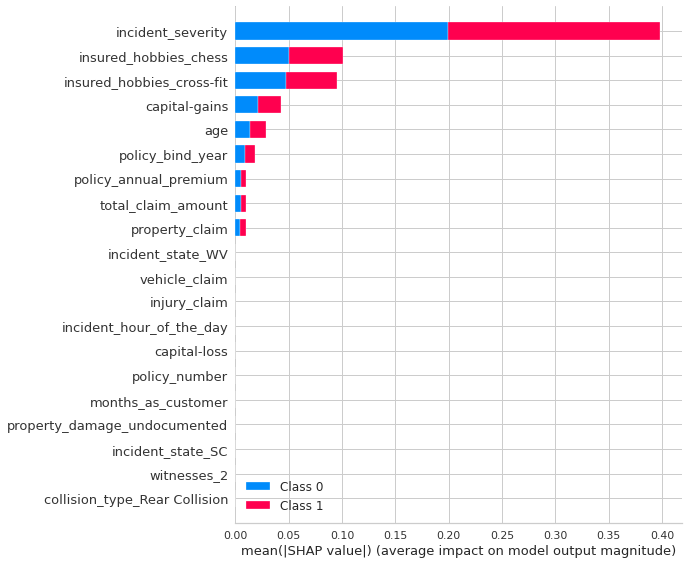

In [22]:
#Model interpretability
classification.interpret_model(tuned_model, plot='summary', save=True)

classification.interpret_model(tuned_model, plot='reason', save=True)

## 10. Model Scoring

In [44]:
def get_prediction(inputdata: dict):
    '''This method is used for predicting the output when appropriate data is fed to the trained model.'''
    df = read_data('s3://ins-data-lake/insfiles/insurance_claims_test.csv')
    df,nom_var, cont_var,ord_var, quan_var = prepare_data(df)
    df_dummied = preprocess_data(df,nom_var)
    try:
        aif_model = classification.load_model(model_name='AIFraud_tuned_model')
        print('Loading from local directory')
    except Exception:
        print('Model not found. Looking for a pretrained one in custom models folder')
        try:
            aif_model = classification.load_model(model_name=os.path.abspath(os.path.join(__file__, os.pardir, 'AIFraud_tuned_model'))) 
            print('Loading from custom models directory')
        except Exception:
            print("Model not found.")
    predictions = classification.predict_model(aif_model, data=df_dummied)
    try:
        predictions.to_csv(os.path.abspath(os.path.join(__file__, os.pardir,"model_output.csv")))
        print("Output saved inside model folder")
    except Exception:
        predictions.to_csv("model_output.csv")
        print("Output saved current working directory")
    pass

In [45]:
get_prediction({})

incident_date 57
policy_bind_date 197
incident_location 199
policy_number 199
auto_model 39
insured_zip 199
Item not found
item doesnt exist
total var count:35 continous var count:18 norminal var count:16
Item not found
Transformation Pipeline and Model Successfully Loaded
Loading from local directory
Output saved current working directory


## 11. Model Onboarding

<div style='font-size:20px; font-weight:bold'> Please save the notebook after any change to ensure the correct code extraction.</div>

In [46]:
save_notebook()

<IPython.core.display.Javascript object>

<div style='font-size:15px; font-weight:bold'> Please execute the following function everytime the notebook is renamed.</div>

*********** PLEASE ENSURE TO EXECUTE THE BELOW SHELL BEFORE PROCEEDING FOR MODEL ONBOARDING ************ 
 			<div style='font-size:15px; font-weight:bold'> Please execute the following cell and provide the model independent and dependent variable information for creation of metadata file.</div>

In [49]:
enter_metadata_information(2)

Button(description='Validate & Save', style=ButtonStyle())

Output()

### 11.1 Push Model to CDMS  
* 			Please execute the following cell to onboard the model to the CDMS server. 
* 			Before onboarding the model, please ensure that the programmable interface for both training and prediction are present in the notebook and working. 
* 			Please execution this cell will push a new version of the model to CDMS

In [50]:
metadata_dict['db_interaction'] = False
onboard(metadata_dict, 
updt_db_cust_mdl=False, 
trained_mdl_type=None )

Creating diagnostics folder and artefacts
Pushing model diagnosis files from last model version V9
Copying /u01/HomeDir/cipuser/Model/CDMS/custom_models/MC1_V8/diagnostic.py to /u01/HomeDir/cipuser/JUPYTER/MC1
Copying /u01/HomeDir/cipuser/Model/CDMS/custom_models/MC1_V8/diagnostic.ini to /u01/HomeDir/cipuser/JUPYTER/MC1
Copying /u01/HomeDir/cipuser/Model/CDMS/custom_models/MC1_V8/ModelDiagnostic.sh to /u01/HomeDir/cipuser/JUPYTER/MC1
Copying /u01/HomeDir/cipuser/Model/CDMS/custom_models/MC1_V8/pred_diagnostic_report.csv to /u01/HomeDir/cipuser/JUPYTER/MC1
'/u01/HomeDir/cipuser/Model/CDMS/custom_models/MC1_V8/pred_diagnostic_report.csv' could not be found
Files updated at:
local workspace '/u01/HomeDir/cipuser/JUPYTER/MC1' are ['custom_model.py', 'metadata.json']
cdms workspace '/u01/HomeDir/cipuser/Model/CDMS/custom_models/MC1_V9' are ['logs.log', 'AIFraud_tuned_model.pkl', 'SHAP summary.png', 'model_output.csv', 'diagnostic.py', 'diagnostic.ini', 'ModelDiagnostic.sh', 'custom_model.py